# Simulating the quantum HOM effect on a quantum computer

Links
This Jupyter notebook can be found at: https://github.com/robhendrik/HOMsimulation

References
* An Jupyter notebook more specifically about the HOM effect can be found Github pages https://robhendrik.github.io/HOMeffect/
* Blogpost describing the HOM effect can be found at https://armchairquantumphysicist.com/. Specifically check https://armchairquantumphysicist.com/2023/04/18/beamsplitters-and-the-quantum-hom-effect/ and https://armchairquantumphysicist.com/2023/04/19/the-hom-effect-explained/
* The original article after which the HOM effect is names is: C. K. Hong, Z. Y. Ou, and L. Mandel, "Measurement of subpicosecond time intervals between two photons by interference", Phys. Rev. Lett. 59, 2044 – Published 2 November 1987

In this notebook we simulate the HOM effect on a quantum computer. The HOM effect is an optical quantum effect where two photons enter a beamsplitter and somehow interact such that they end up together in one of the output ports. Classical physics would predict that there is an equal likelihood of finding the photons together in one output, or finding them separately in different outputs. The quantum effect is what is actually observed by experiment (see references for details).

In this notebook we build a quantum algorithm that correctly predicts the experimentally observationn and run this algorithm on a quantum computer. There is no real quantum advantage (the effect can easily be simulated by a regular computer). The exercise is for learning and for fun.

Contents
- [Introduction: The HOM effect](#The_HOM_effect)
- [Transition matrices from beamsplitter input to output for multi-photon states](#Transition_matrices)
- [Mapping the photons states (Fock states) onto qubit states](#Translation_tables)
- [Defining the qubit transition matrix (the unitary operator)](#qubit_operator)
- [Designing an algorithm with quantum gates simulating the beamsplitter](#Algo_with_quantum_gates)
- [Running the algorithm on a simulator](#Simulator)
- [Running the algorithm on a real quantum computer](#Real)

In [34]:
# Imported libraries
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines
import numpy as np
import math
from IPython.display import Image # for displaying picture
from qutip import * # for quantum simulations
import pandas as pd # used for easily printing tables

# Settings for this notebook
length_of_fock_state = 3 # max number of photons in a channel is 2, so possible states are |0>, |1> or |2>
no_of_channels = 2 # the beamsplitter has two input and two output channels, so we work with two channels that are''mixed' by the beamsplitter
precision =2 # used for printing output)
pd.set_option("display.precision", precision)

<a id="The_HOM_effect"></a>
## Introduction: The HOM effect
In this notebook we use a very simple optical component: A beamsplitter. This beamsplitter has two input ports and two output ports. For single photons we find the expected, and rather boring outcome that the photon either passes through the beamsplitter, or is reflected by the beamsplitter with a probability depending on the reflectance or transmittance of the beamsplitter. For a 50%/50% beamsplitter you would find an input photon with equal likelihood in any of the output ports of the beamsplitter.

However, when using two photons it gets a lot more interesting. We see that when the photons enter form different ports and are fundamentally 'indistinguishable' an effect occurs leading to the two photons always being together in any of the outputs. This 'bunching' is known at the HOM effect, named after Hong, Ou and Mandel (see their paper "Measurement of subpicosecond time intervals between two photons by interference" which mentioned in the references for this notebook)

To model the beamsplitter we define the matrix below. Here the transmission coefficient is $t$ and the reflection coefficient is $r$. These coefficients act on the ampitudes of the electric field. The probability for photons to be transmitted or reflected is the square of the absolute value of these amplitudes. So transmission probability is $|t|^{2}$ and reflection probability is $|tr|^{2}$. If for instance $t = r = \frac{1}{\sqrt{2}}$ the probability for a single photon to be reflected is $r^{2} = \frac{1}{2}$ and the probability to be transmitted is $t^{2} = \frac{1}{2}$. So this would be a 50%/50% beamsplitter equally splitting the light between the output ports. The matrix describing the general beamsplitter is

 $\begin{pmatrix} r & t \\ t & -r \\ \end{pmatrix}$

 For the 50%/50% beamsplitter the matrix looks like 
 
 $\begin{pmatrix} \frac{1}{2} \sqrt{2} & \frac{1}{2} \sqrt{2} \\ \frac{1}{2} \sqrt{2} & -\frac{1}{2} \sqrt{2} \\ \end{pmatrix} =  
 \frac{1}{2} \sqrt{2} \begin{pmatrix} 1 & 1 \\ 1 & -1 \\ \end{pmatrix}$

 For more information on how to describe a beamsplitter with a matrix check out https://en.wikipedia.org/wiki/Beam_splitter or https://www.pas.rochester.edu/~howell/mysite2/Tutorials/Beamsplitter2.pdf.

To describe the light we use Fock states (see https://en.wikipedia.org/wiki/Fock_state). In a Fock state there is a well defined amount or photons in each channel. So if we look at the two input ports of the beamsplitter we could have state $|00>$ with zero photons in either input, or we could have state $|21>$ with 2 photons in one port and one photon in the other port. The HOM effects is such that if we have input state $|11>$ (one photon in each input) we measure output states $|02>$ and $|20>$ with 50% probability each. We never measure $|11>$ at the output.

<a id="Transition_matrices"></a>
## Transition matrices from beamsplitter input to output for multi-photon states

For the beamsplitter we have two input channels and two output channels. When using Fock states the beamsplitter 'transforms' and input state $|nm>$ into and output state $|uv>$. Here $n$ and $m$ are the number of photons in input channels 1 and 2, and $u$ and $v$ are the number of photons in output channels 1 and 2. We can make a transition matrix describing how this transformation happens. This matrix will have for instance a coeffient at indices '10' and '01' which indicates the __amplitude__ for the transition from state $|10>$ at the input to state $|01>$ at the output. If this is __amplitude__ is for instance $\frac{1}{\sqrt{2}}$ the __probability__ to end up in state $|01>$ would be $(\frac{1}{\sqrt{2}})^{2}$ or $\frac{1}{2}$.

As we deal with lossless beamsplitter the total amount of photons in the input and output have to be the (this is the law of conservation of energy, we cannot create photons out of nothing and without loss they can also not disappear). So an input state with one photon ($|10>$ or $|01>$) can only transform to an output state with one photon ($|10>$ or $|01>$). The total probability should be 100%. So if we know that the probability to go from input $|10>$ to output $|01>$ is $\frac{1}{2}$ we automatically know that the probability to from input $|10>$ to output $|10>$ is also $\frac{1}{2}$. We also know that the probability to go from input $|10>$ to for instance output $|10>$, $|11>$ or $|20>$ is zero as the total number of photons is not kept the same.

The transition matrix contains __amplitudes__ and the transition __probability__ is the square of the absolute value of the amplitude. The probability is a real number ranging from 0 to 1. The amplitude can be complex number. We need to calculate with amplitudes to be able to include __quantum interference__ where a probability is reduced due to two amplitudes cancelling eachother for the different ways to get to an component. As explained in https://armchairquantumphysicist.com/2023/04/19/the-hom-effect-explained/ this is the basis for the HOM effect. If we would ignore the amplitude and only calculate with probabilities we would not be able to describe the interesting quantum effects.

Below we define the Python function to calcute the Fock state transition matrix. Here $r$ and $t$ are reflection and transmission amplitudes. For the 50%/50% beamsplitter we take $t = r = \frac{1}{\sqrt{2}}$
```
create_Fock_coefficients(r, t, make_unitary)
```
If the paramater ```make_unitary``` is set to ```False``` we use the transition coefficients defined by the physical system. This leads to a practical issue when modelling. To keep the size of the model finite we have to set a maximum to the number of photons per channel. We do this by setting the parameter ```length_of_fock_state```. If set this to for instance 3 the maximum photon count per channel is 2 (we have 3 options per channel, either 0,1 or 2 photons).
If we limit the photon count per channel to for instance 2, we can have input state $|22>$. This means the output state could be $|31>$ or $|40>$, with photon count per channel that is higher than the earlier set value of 2. But if we extend the basis to include this and allow photon count of 4 per channel the input could be $|44>$ and the output should include $|80>$. We can of course have a different basis as input and output, but that is not practical. Also the system would not be 'revesible' which poses an issue later if we want to model on a quantum computer. So for practical purposes we can set the option ```make_unitary``` to ```True```. In that case the coefficients will be articially set if the total photon count at either input or output is above the maximum defined. So for a maximum photon count per channel set to 2 and ```make_unitary``` set to ```True``` the transition from $|21>$ to $|21>$ will be artificially set to 1 and the transition from $|21>$ to $|03>$ will be zero (so we can leave state $|03>$ out of consideration). This is not the real physics. A real beamsplitter will have a probability to go from $|21>$ to $|03>$. Purely from practical purposes we exclude this. For total photon counts up to 2 the matrix will describe the real system, for higher counts the matrix is artificial and does not describe the real system with ```make_unitary``` set to ```True```.

Below the two transition matrices for the physical system with ```make_unitary = False```. In some rows and columnesn(for $|21>$, $|12>$ and $|22>$ ) the squares of the amplitudes do not add up to 1.  
```
r = t = 1/math.sqrt(2)
make_unitary = False
Fock_coefficients = create_Fock_coefficients(r, t, make_unitary)
```
```
     00    01    02    10    11    12    20    21   22
00  1.0  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.0
01  0.0  0.71  0.00  0.71  0.00  0.00  0.00  0.00  0.0
02  0.0  0.00  0.50  0.00  0.71  0.00  0.50  0.00  0.0
10  0.0 -0.71  0.00  0.71  0.00  0.00  0.00  0.00  0.0
11  0.0  0.00 -0.71  0.00  0.00  0.00  0.71  0.00  0.0
12  0.0  0.00  0.00  0.00  0.00 -0.35  0.00  0.35  0.0
20  0.0  0.00  0.50  0.00 -0.71  0.00  0.50  0.00  0.0
21  0.0  0.00  0.00  0.00  0.00 -0.35  0.00 -0.35  0.0
22  0.0  0.00  0.00  0.00  0.00  0.00  0.00  0.00 -0.5
```

When we model with with ```make_unitary = True``` we artificially set the transition for states with in total more than two photons to 1, and the it becomes a 'nice' transition matrix.
```
r = t = 1/math.sqrt(2)
make_unitary = False
Fock_coefficients = create_Fock_coefficients(r, t, make_unitary)
```
```
     00    01    02    10    11   12    20   21   22
00  1.0  0.00  0.00  0.00  0.00  0.0  0.00  0.0  0.0
01  0.0  0.71  0.00  0.71  0.00  0.0  0.00  0.0  0.0
02  0.0  0.00  0.50  0.00  0.71  0.0  0.50  0.0  0.0
10  0.0 -0.71  0.00  0.71  0.00  0.0  0.00  0.0  0.0
11  0.0  0.00 -0.71  0.00  0.00  0.0  0.71  0.0  0.0
12  0.0  0.00  0.00  0.00  0.00  1.0  0.00  0.0  0.0
20  0.0  0.00  0.50  0.00 -0.71  0.0  0.50  0.0  0.0
21  0.0  0.00  0.00  0.00  0.00  0.0  0.00  1.0  0.0
22  0.0  0.00  0.00  0.00  0.00  0.0  0.00  0.0  1.0
```




An alternative approach would be to limit the set of input and output states only to a specific set (i.e., only look at states with up to 2 photons and exclude the rest). We do that later in this workbook, but already note that when modelling with a register (qu)bits it is convenient to have a number of states that is a power of 2. So we can easily deal with a basis of 2, 4, 8 or 16 states, but have to take specific care when dealing with for instance a basis consisting of 6 states.

In [44]:
def create_Fock_coefficients(r, t, make_unitary):
    Fock_coefficients = dict([])
    for n in range(length_of_fock_state):
        for m in range(length_of_fock_state):
            # n and m are the photon counts for the input state |nm>. 
            # The for loops run through all possible input states |nm> with photon count n and m less than 'length_of_fock_state'
            input_state = str(n) + str(m)
            coeff = [[0 for v in range(2*length_of_fock_state)] for u in range(2*length_of_fock_state)] # initialize at zero
            for i in range(0,n+1):
                for j in range(0,m+1):
                    # u and v are the photon counts in the output state |uv>.
                    # The loops are such that we run through all possible values of u and v such that n+m = u+v 
                    # (so total photon count at input same as at output)
                    # Note that the same value for u and v occur multiple times in the for loop, more ways to creat one output state!
                    v = (n+m) - (i+j)
                    u = (i+j)
                    # the factor from the binomial expansion
                    data = math.comb(n,i)*math.comb(m,j)*(r**(n-i))*(t**(m-j))*(t**(i))*((-r)**(j))
                    # factor in sqrt n for boson raising operation c|n> = sqrt(n+1)|n+1> and l|n> = sqrt(n)|n-1>. <n|a*a|n> = n
                    data = data * math.sqrt(math.factorial(u)*math.factorial(v)/(math.factorial(n)*math.factorial(m)))
                    # total number of photons cannot exceed (length-1) for each of the output channels
                    coeff[u][v] = coeff[u][v] + data
                    # if make_unitary is set to True we have to set all coefficients for output states with 
                    if make_unitary:
                        if n + m >= length_of_fock_state or n + m >= length_of_fock_state:
                            if (n == u) and (m == v):
                                coeff[u][v] = 1.0
                            else:
                                coeff[u][v] = 0.0

            Fock_coefficients[input_state] = {str(u) + str(v): coeff[u][v] for v in range(length_of_fock_state) for u in range(length_of_fock_state)}
    return Fock_coefficients

In [100]:
r = t = 1/math.sqrt(2)
make_unitary = True
Fock_coefficients = create_Fock_coefficients(r, t, make_unitary)
print("Transition matrix between Fock states in 2 channels, with total photon count of maximum 2")
print(pd.DataFrame([[Fock_coefficients[input_state][output_state] for input_state in Fock_coefficients.keys()] for output_state in Fock_coefficients.keys()], columns = list(Fock_coefficients.keys()), index=list(Fock_coefficients.keys())))

Transition matrix between Fock states in 2 channels, with total photon count of maximum 2
     00    01    02    10    11   12    20   21   22
00  1.0  0.00  0.00  0.00  0.00  0.0  0.00  0.0  0.0
01  0.0  0.71  0.00  0.71  0.00  0.0  0.00  0.0  0.0
02  0.0  0.00  0.50  0.00  0.71  0.0  0.50  0.0  0.0
10  0.0 -0.71  0.00  0.71  0.00  0.0  0.00  0.0  0.0
11  0.0  0.00 -0.71  0.00  0.00  0.0  0.71  0.0  0.0
12  0.0  0.00  0.00  0.00  0.00  1.0  0.00  0.0  0.0
20  0.0  0.00  0.50  0.00 -0.71  0.0  0.50  0.0  0.0
21  0.0  0.00  0.00  0.00  0.00  0.0  0.00  1.0  0.0
22  0.0  0.00  0.00  0.00  0.00  0.0  0.00  0.0  1.0


<a id="Translation_tables"></a>
## Mapping the photons states onto qubit states

In this notebook we want to model the HOM effect on ultimately a real quantum computer. This means we need to map the Fock states discussed above on a (qu)bit state. Above transition matrix has a basis of 9 states. So we would need 4 bits, with $2^{4} = 16$ states. As we know that some states in the  Fock state basis are artificially set anyway we can also limit the basis to 8 states and use a register of 3 (qu)bits.

Anyway we will need a mapping table where we map a Fock state on a qubit  register. This is a choice we make. There is no physics prescribing whether we map for state $|01>$ on qubit state '001' or '100'. 

Let's take the simplest approach and follow the ordering of basis states implemented in Python QuTiP anyway. We first show how the Fock states are mapped on the QuTiP bases state via ```create_lookup_Fock_states(length_of_fock_state, no_of_channels)```. We then can do the same and map the QuTiP 'QubitCircuit' states on the same basis via ```create_lookup_QubitCircuit_states```

```
Lookup table for a system with two channels and maximum two photons in each channel (so either 0, 1 or 2 photons per channel)
Fock state <==> Qutip basis state
|00>  <==> 100000000
|10>  <==> 010000000
|20>  <==> 001000000
|01>  <==> 000100000
|11>  <==> 000010000
|21>  <==> 000001000
|02>  <==> 000000100
|12>  <==> 000000010
|22>  <==> 000000001
```
```
Lookup table for a system with 3 qubits
QubitCircuit <==> Qutip basis state
|000>  <==> 10000000
|001>  <==> 01000000
|010>  <==> 00100000
|011>  <==> 00010000
|100>  <==> 00001000
|101>  <==> 00000100
|110>  <==> 00000010
|111>  <==> 00000001
```
If we ignore the 9th state in the Fock state basis (which we do not intend to use anyway, and already did set to an artificial transition coefficient to make the matrix unitary) we can keep the order of the basis and come to the mapping defined in ``` merge_lookups(map, first_lookup, second_lookup) ```

```
Lookup table from Fock states to Qubits
Fock states <==> QubitCircuit qubits
|000>  <==> 00
|001>  <==> 01
|010>  <==> 02
|011>  <==> 10
|100>  <==> 11
|101>  <==> 12
|110>  <==> 20
|111>  <==> 21
```

With this mapping we can define the transition matrix between qubit states to model the beamsplitter (and model the HOM effect)

```
Transition matrix between registers of 3 qubits.
This matrix models the transition between Fock states in 2 channels, with total photon count of maximum 2
     000   001   010   011   100  101   110  111
000  1.0  0.00  0.00  0.00  0.00  0.0  0.00  0.0
001  0.0  0.71  0.00 -0.71  0.00  0.0  0.00  0.0
010  0.0  0.00  0.50  0.00 -0.71  0.0  0.50  0.0
011  0.0  0.71  0.00  0.71  0.00  0.0  0.00  0.0
100  0.0  0.00  0.71  0.00  0.00  0.0 -0.71  0.0
101  0.0  0.00  0.00  0.00  0.00  1.0  0.00  0.0
110  0.0  0.00  0.50  0.00  0.71  0.0  0.50  0.0
111  0.0  0.00  0.00  0.00  0.00  0.0  0.00  1.0
```

In [52]:
def create_lookup_Fock_states(length_of_fock_state, no_of_channels):
    digits = [0]*(length_of_fock_state**no_of_channels)
    states = [[]]
    for c in range(no_of_channels):
        states_new = []
        for state in states:
            for n in range(length_of_fock_state):
                states_new.append(state + [n])
        states = states_new[:]

    lookup = dict([])
    for state in states:
        word = ''.join([str(n) for n in state])
        bit_state = basis(length_of_fock_state,state[0])
        for c in range(1,no_of_channels):
            bit_state = tensor(basis(length_of_fock_state, state[c]), bit_state)
        data = bit_state.full(order="C")
        bit_string = ''.join((['1' if b == 1 else '0' for b in data]))
        lookup[bit_string] = word
    return lookup


In [53]:

print('Lookup table for a system with two channels and maximum two photons in each channel (so either 0, 1 or 2 photons per channel)')
print('Fock state <==> Qutip basis state')
for (key, value) in sorted(create_lookup_Fock_states(length_of_fock_state, no_of_channels).items(), key=lambda x: x[0], reverse=True):
    print("|{}>  <==> {}".format(value,key)) 


Lookup table for a system with two channels and maximum two photons in each channel (so either 0, 1 or 2 photons per channel)
Fock state <==> Qutip basis state
|00>  <==> 100000000
|10>  <==> 010000000
|20>  <==> 001000000
|01>  <==> 000100000
|11>  <==> 000010000
|21>  <==> 000001000
|02>  <==> 000000100
|12>  <==> 000000010
|22>  <==> 000000001


In [74]:
from qutip.qip.circuit import QubitCircuit, Gate
number_of_qubits = 3

def create_lookup_QubitCircuit_states(number_of_qubits):
    digits = [0]*(2**number_of_qubits)
    states = [[]]
    for c in range(number_of_qubits):
        states_new = []
        for state in states:
            for n in range(2):
                states_new.append(state + [n])
        states = states_new[:]

    lookup = dict([])
    for state in states:
        word = ''.join([str(n) for n in state])
        bit_state = basis(2,state[0])
        for c in range(1,number_of_qubits):
            bit_state = tensor(bit_state, basis(2, state[c]))
        data = bit_state.full(order="C")
        bit_string = ''.join((['1' if b == 1 else '0' for b in data]))
        lookup[bit_string] = word
    return lookup


In [75]:
print('Lookup table for a system with 3 qubits')
print('QubitCircuit <==> Qutip basis state')
for (key, value) in sorted(create_lookup_QubitCircuit_states(number_of_qubits).items(), key=lambda x: x[0], reverse=True):
    print("|{}>  <==> {}".format(value,key)) 

Lookup table for a system with 3 qubits
QubitCircuit <==> Qutip basis state
|000>  <==> 10000000
|001>  <==> 01000000
|010>  <==> 00100000
|011>  <==> 00010000
|100>  <==> 00001000
|101>  <==> 00000100
|110>  <==> 00000010
|111>  <==> 00000001


In [119]:
def merge_lookups(map, first_lookup, second_lookup):
    # merge two lookups. If the same value is present in both dictionaries the new lookup has item {key in first lookup: key in second lookup}
    lookup = dict([])
    first_keys = list(first_lookup.keys())
    second_keys = list(second_lookup.keys())
    for index in map:
        lookup[first_lookup[first_keys[index]]] = second_lookup[second_keys[map[index]]]
    return lookup

In [120]:
first_lookup = create_lookup_Fock_states(length_of_fock_state, no_of_channels)
second_lookup = create_lookup_QubitCircuit_states(number_of_qubits)
map = [index for index in range(min(len(first_lookup), len(second_lookup)))]

print('Lookup table from Fock states to Qubits')
print('Fock states <==> QubitCircuit qubits')
for (key, value) in merge_lookups(map, first_lookup, second_lookup).items():
    print("|{}>  <==> {}".format(key, value)) 

Lookup table from Fock states to Qubits
Fock states <==> QubitCircuit qubits
|00>  <==> 000
|01>  <==> 001
|02>  <==> 010
|10>  <==> 011
|11>  <==> 100
|12>  <==> 101
|20>  <==> 110
|21>  <==> 111


In [141]:
# Calculate the transitions coefficients for the Fock states
r = t = 1/math.sqrt(2)
make_unitary = True
Fock_coefficients = create_Fock_coefficients(r, t, make_unitary)

# Define the matrix describing the HOM effect as a transition matrix between the qubit states
first_lookup = create_lookup_Fock_states(length_of_fock_state, no_of_channels)
second_lookup = create_lookup_QubitCircuit_states(number_of_qubits)
map = [index for index in range(min(len(first_lookup), len(second_lookup)))]

lookup_table = merge_lookups(map, first_lookup, second_lookup)
reverse_lookup_table = {value:key for key, value in lookup_table.items()}

qubit_transition_matrix = np.array(
    [[Fock_coefficients[Fock_ver][Fock_hor] for Fock_hor in lookup_table.keys()] for Fock_ver in lookup_table.keys()]
    )

print("Transition matrix between registers of 3 qubits.")
print("This matrix models the transition between Fock states in 2 channels, with total photon count of maximum 2")
print(pd.DataFrame(qubit_transition_matrix, columns = lookup_table.values(), index=lookup_table.values()))

Transition matrix between registers of 3 qubits.
This matrix models the transition between Fock states in 2 channels, with total photon count of maximum 2
     000   001   010   011   100  101   110  111
000  1.0  0.00  0.00  0.00  0.00  0.0  0.00  0.0
001  0.0  0.71  0.00 -0.71  0.00  0.0  0.00  0.0
010  0.0  0.00  0.50  0.00 -0.71  0.0  0.50  0.0
011  0.0  0.71  0.00  0.71  0.00  0.0  0.00  0.0
100  0.0  0.00  0.71  0.00  0.00  0.0 -0.71  0.0
101  0.0  0.00  0.00  0.00  0.00  1.0  0.00  0.0
110  0.0  0.00  0.50  0.00  0.71  0.0  0.50  0.0
111  0.0  0.00  0.00  0.00  0.00  0.0  0.00  1.0


<a id="qubit_operator"></a>
## Defining the qubit transition matrix (the unitary operator)

We use Qiskit to create a quantum circuit that simulates the beamsplitter. The circuit will have three qubit and three classical bits (to store the measurment results).  We have a helper function to cycle through  all input states in our lookup table and determine the probability of the various outcomes (this function is ```get_all_probabilities(circuit, lookup_table)``` ). We also define a helper function to plot the unitary matrix of the quantum circuit (```print_circuit_unitary(circuit, lookup_table)```).

First we create a custom gate which exactly contains the transition matrix defined before as ```qubit_transition_matrix```.:
```
circuit.unitary(Operator(qubit_transition_matrix), circuit.qubits, label='HOM simulation')
```
We get the expected outcome when running the circuit:
```

Input Fock state: |00> (qubit |000>)
---- Outcome Fock state: |00> (qubit |000>) with probability 100%

Input Fock state: |01> (qubit |001>)
---- Outcome Fock state: |10> (qubit |011>) with probability 49%
---- Outcome Fock state: |01> (qubit |001>) with probability 51%

Input Fock state: |02> (qubit |010>)
---- Outcome Fock state: |02> (qubit |010>) with probability 25%
---- Outcome Fock state: |11> (qubit |100>) with probability 50%
---- Outcome Fock state: |20> (qubit |110>) with probability 24%

Input Fock state: |10> (qubit |011>)
---- Outcome Fock state: |10> (qubit |011>) with probability 50%
---- Outcome Fock state: |01> (qubit |001>) with probability 50%

Input Fock state: |11> (qubit |100>)
---- Outcome Fock state: |02> (qubit |010>) with probability 50%
---- Outcome Fock state: |20> (qubit |110>) with probability 50%

Input Fock state: |12> (qubit |101>)
---- Outcome Fock state: |12> (qubit |101>) with probability 100%

Input Fock state: |20> (qubit |110>)
---- Outcome Fock state: |11> (qubit |100>) with probability 50%
---- Outcome Fock state: |02> (qubit |010>) with probability 26%
---- Outcome Fock state: |20> (qubit |110>) with probability 23%

Input Fock state: |21> (qubit |111>)
---- Outcome Fock state: |21> (qubit |111>) with probability 100%
```
If we then check the unitary matrix for the total circuit we see indeed the correct results
```
     000   001   010   011   100  101   110  111
000  1.0     .     .     .     .    .     .    .
001    .  0.71     . -0.71     .    .     .    .
010    .     .   0.5     . -0.71    .   0.5    .
011    .  0.71     .  0.71     .    .     .    .
100    .     .  0.71     .     .    . -0.71    .
101    .     .     .     .     .  1.0     .    .
110    .     .   0.5     .  0.71    .   0.5    .
111    .     .     .     .     .    .     .  1.0
```

So this is not very exciting. We have simply created a custom gate by using the transition coefficients between the different Fock states and by using a lookup table mapping the Fock states on the qubit states. However, with this infrastructure setup we can now try to build a quantum circuit from more standard gates (so not the custom gate) to come to the same result. 

In [155]:
# Create the quantum circuit using Qiskit
from qiskit import *
#from qiskit import QuantumCircuit, execute
from qiskit.quantum_info.operators import Operator
#from qiskit import Aer
from qiskit_aer import AerSimulator

In [156]:
# Define a function to loop through all qubit states in the lookup_table and return the probabilities of the results for a given quantum circuit

def get_all_probabilities(circuit, lookup_table):
    outcomes = dict([])
    for qubit_state in lookup_table.values(): 
        number_of_shots = 1000
        simulator = AerSimulator()
        temp_q = QuantumRegister(circuit.num_qubits,'q')
        temp_c = ClassicalRegister(circuit.num_clbits,'c')
        if len(qubit_state) != circuit.num_qubits:
            print('Length of qubit state in lookup table to matching the quantum circuit')
        temp_circuit = QuantumCircuit(temp_q,temp_c)
        temp_circuit.initialize(qubit_state, temp_circuit.qubits)
        temp_circuit = temp_circuit.compose(circuit)
        temp_circuit.measure([i for i in range(circuit.num_qubits)], [i for i in range(circuit.num_clbits)])
        job = simulator.run(temp_circuit, shots=number_of_shots)
        result = job.result()
        counts = result.get_counts(temp_circuit)
        for word in counts.keys():
            counts[word] = counts[word]/number_of_shots
        outcomes.update({qubit_state : counts})
    return outcomes

# Define a function to get an print the overall unitary for a given circuit
def print_circuit_unitary(circuit, lookup_table):
    precision = 2
    backend = Aer.get_backend('unitary_simulator')
    job = execute(circuit, backend)
    result = job.result()
    matrix = np.asarray(result.get_unitary(circuit,precision)).round(precision)
    table = [[0 for j in range(len(lookup_table.values()))] for i in range(len(lookup_table.values()))]
    for index_h, bit_h in enumerate(lookup_table.values()):
        for index_v, bit_v in enumerate(lookup_table.values()):
            number = matrix[int(bit_h,2)][int(bit_v,2)].real
            if number != 0:
                table[index_h][index_v] = matrix[int(bit_h,2)][int(bit_v,2)].real
            else:
                table[index_h][index_v] = '.'
    df = pd.DataFrame(table, columns = lookup_table.values(), index=lookup_table.values())
    print(df)
    return
            

In [426]:
# Define a quantum circuit with a custom unitary build from the known transition matrix
q = QuantumRegister(3,'q')
c = ClassicalRegister(3,'c')
circuit_custom_unitary = QuantumCircuit(q,c)

circuit_custom_unitary.unitary(Operator(qubit_transition_matrix), circuit.qubits, label='HOM simulation')

outcomes = get_all_probabilities(circuit_custom_unitary, lookup_table)
for input_qubit_state, outcome in outcomes.items():
    print("\nInput Fock state: |{}> (qubit |{}>)".format(reverse_lookup_table[input_qubit_state], input_qubit_state))
    for output_qubit_state, probability in outcome.items():
        print(
            "---- Outcome Fock state: |{}> (qubit |{}>) with probability {:.0%}".format(
            reverse_lookup_table[output_qubit_state], 
            output_qubit_state, 
            probability)
            )


Input Fock state: |00> (qubit |000>)
---- Outcome Fock state: |00> (qubit |000>) with probability 100%

Input Fock state: |01> (qubit |001>)
---- Outcome Fock state: |01> (qubit |001>) with probability 51%
---- Outcome Fock state: |10> (qubit |011>) with probability 49%

Input Fock state: |02> (qubit |010>)
---- Outcome Fock state: |20> (qubit |110>) with probability 23%
---- Outcome Fock state: |11> (qubit |100>) with probability 52%
---- Outcome Fock state: |02> (qubit |010>) with probability 24%

Input Fock state: |10> (qubit |011>)
---- Outcome Fock state: |01> (qubit |001>) with probability 51%
---- Outcome Fock state: |10> (qubit |011>) with probability 49%

Input Fock state: |11> (qubit |100>)
---- Outcome Fock state: |02> (qubit |010>) with probability 50%
---- Outcome Fock state: |20> (qubit |110>) with probability 50%

Input Fock state: |12> (qubit |101>)
---- Outcome Fock state: |12> (qubit |101>) with probability 100%

Input Fock state: |20> (qubit |110>)
---- Outcome Fock

In [427]:
print_circuit_unitary(circuit_custom_unitary, lookup_table)

     000   001   010   011   100  101   110  111
000  1.0     .     .     .     .    .     .    .
001    .  0.71     . -0.71     .    .     .    .
010    .     .   0.5     . -0.71    .   0.5    .
011    .  0.71     .  0.71     .    .     .    .
100    .     .  0.71     .     .    . -0.71    .
101    .     .     .     .     .  1.0     .    .
110    .     .   0.5     .  0.71    .   0.5    .
111    .     .     .     .     .    .     .  1.0


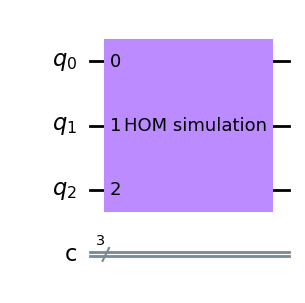

In [428]:
circuit_custom_unitary.draw(output='mpl')

<a id="Algo_with_quantum_gates"></a>
## Designing an algorithm with quantum gates simulating the beamsplitter
We want to create a quantum circuit to simulate the beamsplitter and the HOM effect using standard gates. The goal is to create the same unitary matrix as we had from the custom gate defined in previous section. Obvsiouly there are automated functions available to do this (like Qiskit transpile), but is insightfull to try by hand. An easy and step-by-step way to resolve this manually is to start from the custom gate and then extend with standard gates to turn the matrix into the identity matrix. So we want to get to $I = M \cdot Gate_1 \cdot Gate_2 \cdot Gate_3 \ldots$ (where $I$ is the identity matrix, $M$ the custom unitary and $Gate_i$ a standard gate). So we add gates to the custom gate to create a circuit which does nothing. We then know that the added gates are the reverse of the custom gate, and that reversing the added standard gates should replicate the custom gate. So 

$\begin{array}{lcl}
I & = & M \cdot M^{-1} \\[5pts]
I & = & M \cdot Gate_1 \cdot Gate_2 \cdot Gate_3 \ldots Gate_{n-1} \cdot Gate_n \\[5pts]
M^{-1} & = & Gate_1 \cdot Gate_2 \cdot Gate_3 \ldots Gate_{n-1} \cdot Gate_n \\[5pts]
M & = & (Gate_1 \cdot Gate_2 \cdot Gate_3 \ldots Gate_{n-1} \cdot Gate_n)^{-1}  \\[5pts]
M & = & Gate_n^{-1} \cdot Gate_{n-1}^{-1} \ldots Gate_3^{-1} \cdot Gate_2^{-1} \cdot Gate_1^{-1} 
\end{array}$

We start by the full unitary matrix which comes from our 'custom' 
``` circuit.unitary(Operator(qubit_transition_matrix), circuit.qubits, label='HOM simulation') ```
```
This is the orginal 'custom gate'
     000   001   010   011   100  101   110  111
000  1.0     .     .     .     .    .     .    .
001    .  0.71     . -0.71     .    .     .    .
010    .     .   0.5     . -0.71    .   0.5    .
011    .  0.71     .  0.71     .    .     .    .
100    .     .  0.71     .     .    . -0.71    .
101    .     .     .     .     .  1.0     .    .
110    .     .   0.5     .  0.71    .   0.5    .
111    .     .     .     .     .    .     .  1.0
```
 The idea is now to add gates after this custom gate to ulimately get to the identity transformation. We can start by removing the mixing between states '001' and '011'.

```
circuit.x(2)
circuit.unitary(CCH, [q[1], q[0], q[2]], label='CCH')
circuit.x(2)
```
```
     000  001   010  011   100  101   110  111
000  1.0    .     .    .     .    .     .    .
001    .  1.0     .    .     .    .     .    .
010    .    .   0.5    . -0.71    .   0.5    .
011    .    .     . -1.0     .    .     .    .
100    .    .  0.71    .     .    . -0.71    .
101    .    .     .    .     .  1.0     .    .
110    .    .   0.5    .  0.71    .   0.5    .
111    .    .     .    .     .    .     .  1.0
```
We see that for states '001' and '011' the matrix has simplified and these states only transition to themselves. The idea is to continue untill we have all 1's on the diagonal. Let's remove the factor '0.5' and '-0.5'
```
circuit.x(0)
circuit.unitary(CCH, [q[2], q[0], q[1]], label='CCH')
circuit.x(0)
 ```
 ```
     000  001   010  011  100  101   110  111
000  1.0    .     .    .    .    .     .    .
001    .  1.0     .    .    .    .     .    .
010    .    .  0.71    .    .    .  0.71    .
011    .    .     . -1.0    .    .     .    .
100    .    .  0.71    .    .    . -0.71    .
101    .    .     .    .    .  1.0     .    .
110    .    .     .    . -1.0    .     .    .
111    .    .     .    .    .    .     .  1.0
 ```

A few more steps to get to a fully diagonal matrix
 ```
 circuit.x(0)
circuit.unitary(CCH, [q[2], q[0], q[1]], label='CCH')
circuit.toffoli(2,0,1)
circuit.unitary(CCH, [q[2], q[0], q[1]], label='CCH')
circuit.x(0)
 ```

 ```
     000  001  010  011  100  101  110  111
000  1.0    .    .    .    .    .    .    .
001    .  1.0    .    .    .    .    .    .
010    .    .  1.0    .    .    .    .    .
011    .    .    . -1.0    .    .    .    .
100    .    .    .    . -1.0    .    .    .
101    .    .    .    .    .  1.0    .    .
110    .    .    .    .    .    .  1.0    .
111    .    .    .    .    .    .    .  1.0
 ```

Basically we are there, but to get to the full identity matrix let's also remove the minus sign for states '011' and '100'
 ```
circuit.cnot(control_qubit=2, target_qubit=0)
circuit.cnot(control_qubit=2, target_qubit=1)
circuit.cp(math.pi, control_qubit=0, target_qubit=1)
circuit.cnot(control_qubit=2, target_qubit=0)
circuit.cnot(control_qubit=2, target_qubit=1)
 ```
 ```
     000  001  010  011  100  101  110  111
000  1.0    .    .    .    .    .    .    .
001    .  1.0    .    .    .    .    .    .
010    .    .  1.0    .    .    .    .    .
011    .    .    .  1.0    .    .    .    .
100    .    .    .    .  1.0    .    .    .
101    .    .    .    .    .  1.0    .    .
110    .    .    .    .    .    .  1.0    .
111    .    .    .    .    .    .    .  1.0
 ```

 We now have added standard gates to our custom gate to get to the identity matrix. By inverting this sequence of standard gates we can build our custom gate. 

In [403]:
# Define the double controlled Hadamard gate as a 'helper'. later we see how to build this from more elementary gates.
s = math.sqrt(2)/2
CCH = Operator([
    [1, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, s, s],
    [0, 0, 0, 0, 0, 0, s, -s]
])

In [404]:
# Define a quantum circuit with a custom unitary build from the known transition matrix
q = QuantumRegister(3,'q')
c = ClassicalRegister(3,'c')
circuit = QuantumCircuit(q,c)
circuit.unitary(Operator(qubit_transition_matrix), circuit.qubits, label='HOM simulation')
print("This is the orginal 'custom gate'")
print_circuit_unitary(circuit, lookup_table)

This is the orginal 'custom gate'
     000   001   010   011   100  101   110  111
000  1.0     .     .     .     .    .     .    .
001    .  0.71     . -0.71     .    .     .    .
010    .     .   0.5     . -0.71    .   0.5    .
011    .  0.71     .  0.71     .    .     .    .
100    .     .  0.71     .     .    . -0.71    .
101    .     .     .     .     .  1.0     .    .
110    .     .   0.5     .  0.71    .   0.5    .
111    .     .     .     .     .    .     .  1.0


In [405]:

circuit.x(2)
circuit.unitary(CCH, [q[1], q[0], q[2]], label='CCH')
circuit.x(2)
print_circuit_unitary(circuit, lookup_table)

     000  001   010  011   100  101   110  111
000  1.0    .     .    .     .    .     .    .
001    .  1.0     .    .     .    .     .    .
010    .    .   0.5    . -0.71    .   0.5    .
011    .    .     . -1.0     .    .     .    .
100    .    .  0.71    .     .    . -0.71    .
101    .    .     .    .     .  1.0     .    .
110    .    .   0.5    .  0.71    .   0.5    .
111    .    .     .    .     .    .     .  1.0


In [406]:
circuit.x(0)
circuit.unitary(CCH, [q[2], q[0], q[1]], label='CCH')
circuit.toffoli(2,0,1)
circuit.unitary(CCH, [q[2], q[0], q[1]], label='CCH')
circuit.x(0)
print_circuit_unitary(circuit, lookup_table)

     000  001  010  011  100  101  110  111
000  1.0    .    .    .    .    .    .    .
001    .  1.0    .    .    .    .    .    .
010    .    .  1.0    .    .    .    .    .
011    .    .    . -1.0    .    .    .    .
100    .    .    .    . -1.0    .    .    .
101    .    .    .    .    .  1.0    .    .
110    .    .    .    .    .    .  1.0    .
111    .    .    .    .    .    .    .  1.0


In [407]:
circuit.cnot(control_qubit=2, target_qubit=0)
circuit.cnot(control_qubit=2, target_qubit=1)
circuit.cp(math.pi, control_qubit=0, target_qubit=1)
circuit.cnot(control_qubit=2, target_qubit=0)
circuit.cnot(control_qubit=2, target_qubit=1)

print_circuit_unitary(circuit, lookup_table)

     000  001  010  011  100  101  110  111
000  1.0    .    .    .    .    .    .    .
001    .  1.0    .    .    .    .    .    .
010    .    .  1.0    .    .    .    .    .
011    .    .    .  1.0    .    .    .    .
100    .    .    .    .  1.0    .    .    .
101    .    .    .    .    .  1.0    .    .
110    .    .    .    .    .    .  1.0    .
111    .    .    .    .    .    .    .  1.0


We can draw the circuit that starts with the custom gate and ultimately result in the identity gate. If we only take the gates behind the custom gate and invert their order we should get the custom gate back. 

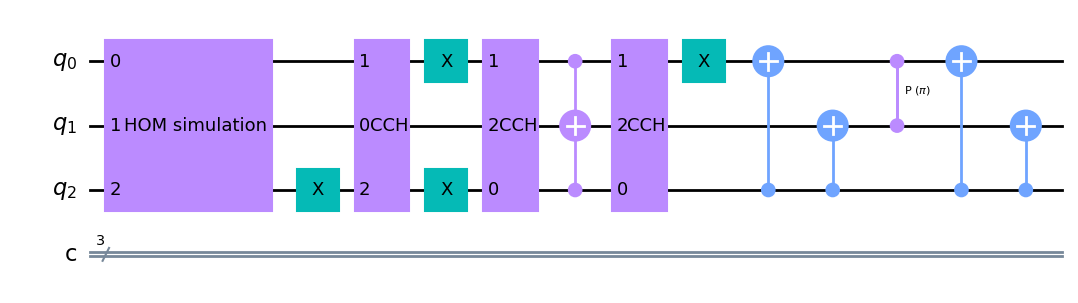

In [414]:
circuit.draw(output='mpl')

In [417]:
# Define a quantum circuit with a custom unitary build from the known transition matrix
q = QuantumRegister(3,'q')
c = ClassicalRegister(3,'c')
circuit_manual = QuantumCircuit(q,c)
circuit_manual.cnot(control_qubit=2, target_qubit=0)
circuit_manual.cnot(control_qubit=2, target_qubit=1)
circuit_manual.cp(math.pi, control_qubit=0, target_qubit=1)
circuit_manual.cnot(control_qubit=2, target_qubit=0)
circuit_manual.cnot(control_qubit=2, target_qubit=1)
circuit_manual.x(0)
circuit_manual.unitary(CCH, [q[2], q[0], q[1]], label='CCH')
circuit_manual.toffoli(2,0,1)
circuit_manual.unitary(CCH, [q[2], q[0], q[1]], label='CCH')
circuit_manual.x(0)
circuit_manual.x(2)
circuit_manual.unitary(CCH, [q[1], q[0], q[2]], label='CCH')
circuit_manual.x(2)
print_circuit_unitary(circuit_manual, lookup_table)

     000   001   010   011   100  101   110  111
000  1.0     .     .     .     .    .     .    .
001    .  0.71     . -0.71     .    .     .    .
010    .     .   0.5     . -0.71    .   0.5    .
011    .  0.71     .  0.71     .    .     .    .
100    .     .  0.71     .     .    . -0.71    .
101    .     .     .     .     .  1.0     .    .
110    .     .   0.5     .  0.71    .   0.5    .
111    .     .     .     .     .    .     .  1.0


Indeed this circuit of standard gates exacly replicates the custom gate. The circuit is drawn below.

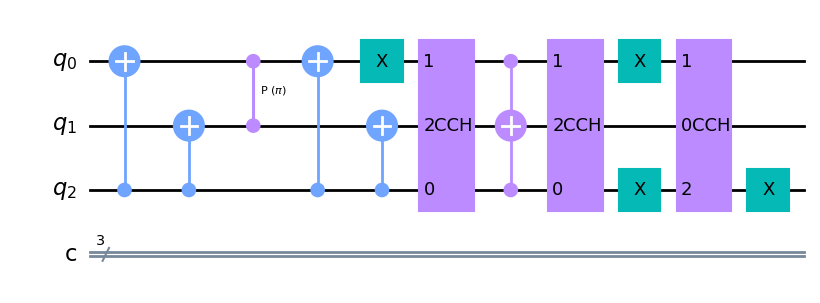

In [409]:
circuit_manual.draw(output='mpl')

The disadvantage of our circuit is that it contains double controlled gates. We can easily replace them by single controlled gates using the right decomposition. First decompose the double controlled Hadamard gate. 

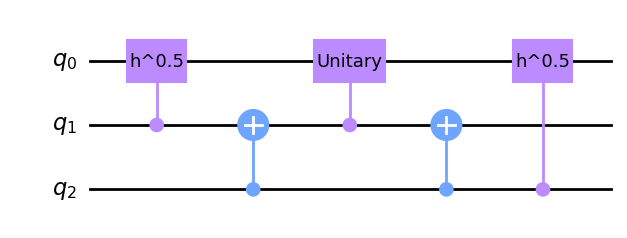

In [410]:
from qiskit.circuit.library import HGate
gate = HGate().power(1/2).control(1)

from qiskit import QuantumCircuit
circuit_CCH = QuantumCircuit(3)
circuit_CCH.append(gate, [1,0])
circuit_CCH.cnot(target_qubit=1, control_qubit=2)
circuit_CCH.append(gate.inverse(), [1,0])
circuit_CCH.cnot(target_qubit=1, control_qubit=2)
circuit_CCH.append(gate, [2,0])
circuit_CCH.draw('mpl')

In [411]:
print_circuit_unitary(circuit_CCH, lookup_table)

     000  001  010  011  100  101   110   111
000  1.0    .    .    .    .    .     .     .
001    .  1.0    .    .    .    .     .     .
010    .    .  1.0    .    .    .     .     .
011    .    .    .  1.0    .    .     .     .
100    .    .    .    .  1.0    .     .     .
101    .    .    .    .    .  1.0     .     .
110    .    .    .    .    .    .  0.71  0.71
111    .    .    .    .    .    .  0.71 -0.71


Then decompose the Toffoli gate, or double controlled NOT gate into only 2-qubit gates:

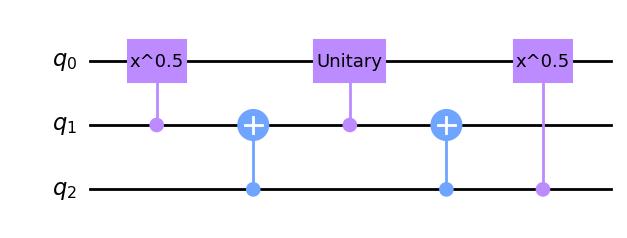

In [412]:
from qiskit.circuit.library import XGate
gate = XGate().power(1/2).control(1)

from qiskit import QuantumCircuit
circuit_CCX = QuantumCircuit(3)
circuit_CCX.append(gate, [1,0])
circuit_CCX.cnot(target_qubit=1, control_qubit=2)
circuit_CCX.append(gate.inverse(), [1,0])
circuit_CCX.cnot(target_qubit=1, control_qubit=2)
circuit_CCX.append(gate, [2,0])
circuit_CCX.draw('mpl')

In [413]:
print_circuit_unitary(circuit_CCX, lookup_table)

     000  001  010  011  100  101  110  111
000  1.0    .    .    .    .    .    .    .
001    .  1.0    .    .    .    .    .    .
010    .    .  1.0    .    .    .    .    .
011    .    .    .  1.0    .    .    .    .
100    .    .    .    .  1.0    .    .    .
101    .    .    .    .    .  1.0    .    .
110    .    .    .    .    .    .    .  1.0
111    .    .    .    .    .    .  1.0    .


In [433]:
# Build our circuit only including 2 - qubit gates by decomposing the 3-qubit gates used before
q = QuantumRegister(3,'q')
c = ClassicalRegister(3,'c')
circuit_manual_2 = QuantumCircuit(q,c)
circuit_manual_2.cnot(control_qubit=2, target_qubit=0)
circuit_manual_2.cnot(control_qubit=2, target_qubit=1)
circuit_manual_2.cp(math.pi, control_qubit=0, target_qubit=1)
circuit_manual_2.cnot(control_qubit=2, target_qubit=0)
circuit_manual_2.cnot(control_qubit=2, target_qubit=1)
circuit_manual_2.x(0)
circuit_manual_2.compose(circuit_CCH, [2,0,1], inplace=True)
circuit_manual_2.compose(circuit_CCX, [1,0,2], inplace=True)
circuit_manual_2.compose(circuit_CCH, [2,0,1], inplace=True)
circuit_manual_2.x(0)
circuit_manual_2.x(2)
circuit_manual_2.compose(circuit_CCH, [1,0,2], inplace=True)
circuit_manual_2.x(2)
print_circuit_unitary(circuit_manual_2, lookup_table)

     000   001   010   011   100  101   110  111
000  1.0     .     .     .     .    .     .    .
001    .  0.71     . -0.71     .    .     .    .
010    .     .   0.5     . -0.71    .   0.5    .
011    .  0.71     .  0.71     .    .     .    .
100    .     .  0.71     .     .    . -0.71    .
101    .     .     .     .     .  1.0     .    .
110    .     .   0.5     .  0.71    .   0.5    .
111    .     .     .     .     .    .     .  1.0


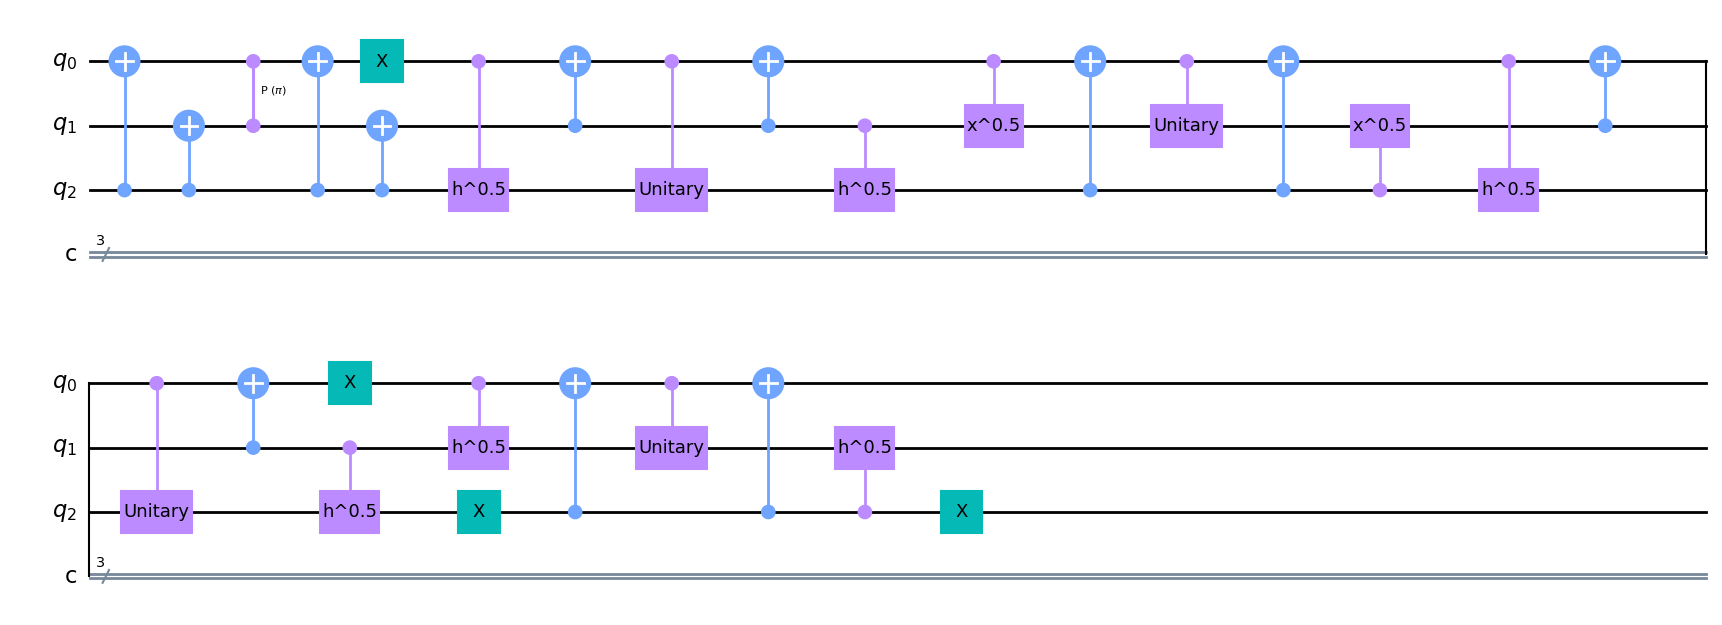

In [434]:
circuit_manual_2.draw(output='mpl')

### In summary

> In this section we started of with a 3 qubit quantum circuit and a single 'custom' gate. The circuit is called ```circuit_custom_unitary```The custom gate was defined by the unitary matrix describing the transition between Fock states for our beamsplitter. With the propose mapping in the ```lookup_table```.
> We then manually decomposed the circuit by using three qubit gates (the double controlled Hadamard gate) and the double controlled NOT gate (aka Toffoli gate). This circuit is called ```circuit_manual```
> We then manually further decomposed the circuit by using only 2 qubit gates. The result is called ```circuit_manual_2```
We can continue and for instance include the allowed coupling between qubits in a specific execution of the quantum computer (for instance, by adding swap gates we can make sure only neighbouring qubits control eachother, and re-write gates where qubit 0 controls qubit 2). However, before execution on a quantum device the circuit is transpiled anyway and those algorithms are more specific and more efficient than we can be manually. So we stop now with the circuit that simulates the beamsplitter using only standard, single and two qubit gates.


<a id="Simulator"></a>
## Running the algorithm on a simulator


<a id="Real"></a>
## Running the algorithm on a real quantum computer

In [489]:
from qiskit.providers.fake_provider import FakeLimaV2
from qiskit.tools.visualization import plot_histogram
backend = FakeLimaV2()
#backend = AerSimulator()
q = QuantumRegister(3,'q')
c = ClassicalRegister(3,'c')
circuit_manual_2 = QuantumCircuit(q,c)
circuit_manual_2.cnot(control_qubit=2, target_qubit=0)
circuit_manual_2.cnot(control_qubit=2, target_qubit=1)
circuit_manual_2.cp(math.pi, control_qubit=0, target_qubit=1)
circuit_manual_2.cnot(control_qubit=2, target_qubit=0)
circuit_manual_2.cnot(control_qubit=2, target_qubit=1)
circuit_manual_2.x(0)
circuit_manual_2.compose(circuit_CCH, [2,0,1], inplace=True)
circuit_manual_2.compose(circuit_CCX, [1,0,2], inplace=True)
circuit_manual_2.compose(circuit_CCH, [2,0,1], inplace=True)
circuit_manual_2.x(0)
circuit_manual_2.x(2)
circuit_manual_2.compose(circuit_CCH, [1,0,2], inplace=True)
circuit_manual_2.x(2)


In [497]:
# Run the transpiled circuit using the simulated fake backend
q = QuantumRegister(3,'q')
c = ClassicalRegister(3,'c')
initial_states = lookup_table.values()
list_of_circuits = []
for state in initial_states:
    circuit_in_list = QuantumCircuit(q,c)
    circuit_in_list.initialize(state, q)
    circuit_in_list.compose(circuit_manual, [0, 1, 2], inplace=True)
    circuit_in_list.measure_all()
    transpiled_circuit = transpile(circuit_in_list, backend)
    list_of_circuits.append(transpiled_circuit)

job = backend.run(list_of_circuits)
matrix = []
for index in range(len(initial_states)):
    res = job.result().get_counts(index)
    matrix_line = []
    for output_state in lookup_table.values():
        word = output_state + ' 000'
        if word in res.keys():
            matrix_line.append(res[word])
        else:
            matrix_line.append(0)
    matrix.append(matrix_line)
#print(job.result())
#plot_histogram(counts)

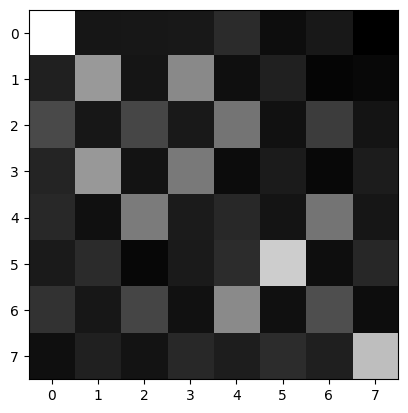

In [498]:

fig, ax = plt.subplots()
im = ax.imshow(matrix, cmap = 'gray')

In [492]:
print(matrix)

[[555, 114, 77, 98, 64, 45, 58, 13], [143, 351, 56, 308, 31, 72, 28, 35], [122, 77, 204, 65, 292, 63, 163, 38], [96, 332, 95, 301, 42, 47, 51, 60], [113, 67, 243, 60, 123, 79, 281, 58], [57, 105, 47, 71, 102, 513, 53, 76], [101, 79, 168, 75, 296, 79, 173, 53], [61, 82, 68, 75, 85, 114, 93, 446]]
